In [10]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
from pytorch_tabnet.tab_model import TabNetClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
N_Samples = 100000

In [3]:
try:
    data = pd.read_csv(f'../Datasets/dataset_original.csv')
except FileNotFoundError:
    print("Error: No se encontró el archivo 'dataset_original.csv'.")
    exit()

In [4]:
target_column = 'diabetes'
categorical_features = ['gender', 'smoking_history']
numerical_features = [col for col in data.columns if col not in categorical_features + [target_column]]

label_encoders_X = {}
for col in categorical_features:
    le = LabelEncoder()
    data[col] = data[col].astype(str)
    data[col] = le.fit_transform(data[col])
    label_encoders_X[col] = le

In [5]:
min_class_count = data['diabetes'].value_counts().min()
if N_Samples > len(data) or int(N_Samples * data['diabetes'].value_counts(normalize=True).min()) > min_class_count:
     print(f"Advertencia: El tamaño de muestra es muy grande. Se usará el dataset completo.")
     data = data.copy()
else:
    proportions = data['diabetes'].value_counts(normalize=True)
    data = data.groupby('diabetes', group_keys=False).apply(
        lambda x: x.sample(int(N_Samples * proportions[x.name]), random_state=42)
    )

print(f"Dataset para el entrenamiento ahora tiene {len(data)} filas.")
print("\nProporción de clases en el nuevo dataset:")
print(data['diabetes'].value_counts(normalize=True))

Dataset para el entrenamiento ahora tiene 100000 filas.

Proporción de clases en el nuevo dataset:
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


In [6]:
data[target_column] = data[target_column].astype(int)

X = data.drop(columns=[target_column])
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train.loc[:, numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

In [7]:
cat_idxs = [X.columns.get_loc(col) for col in categorical_features]
cat_dims = [len(le.classes_) for le in label_encoders_X.values()]

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
weighted_loss_fn = torch.nn.CrossEntropyLoss()

clf = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    optimizer_params=dict(lr=1e-3),
    optimizer_fn=torch.optim.Adam,
    verbose=1,
    seed=42
)

print(f"\n Iniciando Entrenamiento de TabNet:{' ' + DEVICE.upper()}")
clf.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    patience=10,
    max_epochs=100,
    eval_metric=['accuracy', 'logloss'],
    loss_fn=weighted_loss_fn,
    batch_size=256
)


 Iniciando Entrenamiento de TabNet: CPU
epoch 0  | loss: 0.35083 | val_0_accuracy: 0.9497  | val_0_logloss: 0.14986 |  0:00:06s
epoch 1  | loss: 0.14359 | val_0_accuracy: 0.95975 | val_0_logloss: 0.11854 |  0:00:13s
epoch 2  | loss: 0.12915 | val_0_accuracy: 0.9616  | val_0_logloss: 0.11223 |  0:00:20s
epoch 3  | loss: 0.12266 | val_0_accuracy: 0.9604  | val_0_logloss: 0.10988 |  0:00:27s
epoch 4  | loss: 0.11756 | val_0_accuracy: 0.9628  | val_0_logloss: 0.10623 |  0:00:33s
epoch 5  | loss: 0.11235 | val_0_accuracy: 0.96665 | val_0_logloss: 0.09924 |  0:00:40s
epoch 6  | loss: 0.10908 | val_0_accuracy: 0.96665 | val_0_logloss: 0.09861 |  0:00:47s
epoch 7  | loss: 0.10677 | val_0_accuracy: 0.96805 | val_0_logloss: 0.09529 |  0:00:55s
epoch 8  | loss: 0.10334 | val_0_accuracy: 0.9694  | val_0_logloss: 0.09376 |  0:01:04s
epoch 9  | loss: 0.10128 | val_0_accuracy: 0.96845 | val_0_logloss: 0.09383 |  0:01:11s
epoch 10 | loss: 0.09968 | val_0_accuracy: 0.9704  | val_0_logloss: 0.09141 |  

In [11]:
directorio = os.getcwd()
carpeta = "../Guardar_modelo/TabNet"
archivo_xgb = f'Binary_TabNet_{N_Samples}'

ruta = os.path.join(directorio, carpeta, archivo_xgb)

directorio_final_para_guardar = os.path.dirname(ruta)
os.makedirs(directorio_final_para_guardar, exist_ok=True)

clf.save_model(ruta)

Successfully saved model at c:\Users\tcidm\OneDrive\Escritorio\Material U\DeepLearning\ProyectoDeepLearning\Modelo_TabNet\../Guardar_modelo/TabNet\Binary_TabNet_100000.zip


'c:\\Users\\tcidm\\OneDrive\\Escritorio\\Material U\\DeepLearning\\ProyectoDeepLearning\\Modelo_TabNet\\../Guardar_modelo/TabNet\\Binary_TabNet_100000.zip'


--- Resultados de la Evaluación Final ---
Precisión (Accuracy) en el conjunto de prueba: 0.9725

Reporte de Clasificación:
              precision    recall  f1-score   support

 No Diabetes       0.97      1.00      0.99     18300
    Diabetes       1.00      0.68      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000


Matriz de Confusión:


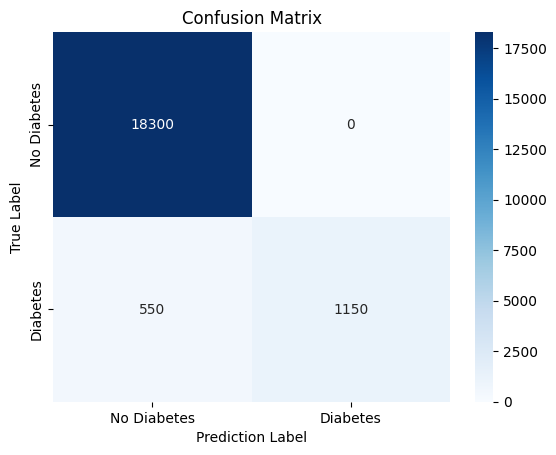


Curva de Pérdida del Entrenamiento:


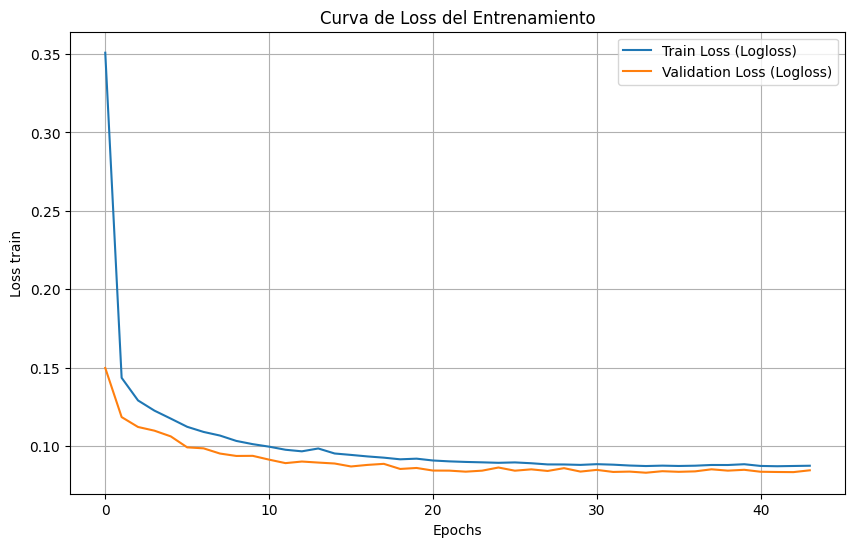

In [ ]:
#Carga del modelo guardado
#preTrained = TabNetClassifier()
#preTrained.load_model(ruta)

y_pred = clf.predict(X_test_np)
test_accuracy = accuracy_score(y_test_np, y_pred)

print("\n--- Resultados de la Evaluación Final ---")
print(f"Precisión (Accuracy) en el conjunto de prueba: {test_accuracy:.4f}")

print("\nReporte de Clasificación:")
print(classification_report(y_test_np, y_pred, target_names=['No Diabetes', 'Diabetes']))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test_np, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Prediction Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nCurva de Pérdida del Entrenamiento:")
train_loss = clf.history['loss']
val_loss = clf.history['val_0_logloss']
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss (Logloss)')
plt.plot(val_loss, label='Validation Loss (Logloss)')
plt.title('Curva de Loss del Entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss train')
plt.legend()
plt.grid(True)
plt.show()